In [73]:
import pandas as pd
import re
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras import layers
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.utils.vis_utils import plot_model

In [14]:
np.random.seed(13)

In [15]:
# ids_with_target_error = [328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226]
# train.loc[train['id'].isin(ids_with_target_error),'target'] = 0

In [16]:
train = pd.read_csv('csv/train.csv')
test  = pd.read_csv('csv/test.csv')

In [17]:
len_elmo = 1024
len_bert = 768
len_w2v = 300
len_glove = 200

In [18]:
bert_train = np.loadtxt("train_embedding_file_bert.txt").reshape(len(train.index),len_bert)
bert_train.shape

(7613, 768)

In [19]:
bert_test = np.loadtxt("test_embedding_file_bert.txt").reshape(len(test.index),len_bert)
bert_test.shape

(3263, 768)

In [20]:
elmo_train = np.loadtxt("train_embedding_file_elmo.txt").reshape(len(train.index),len_elmo)
elmo_train.shape

(7613, 1024)

In [21]:
elmo_test = np.loadtxt("test_embedding_file_elmo.txt").reshape(len(test.index),len_elmo)
elmo_test.shape

(3263, 1024)

In [22]:
w2v_train = np.loadtxt("train_embedding_file_w2v(norm).txt").reshape(len(train.index),len_w2v)
w2v_train.shape

(7613, 300)

In [23]:
w2v_test = np.loadtxt("test_embedding_file_w2v(norm).txt").reshape(len(test.index),len_w2v)
w2v_test.shape

(3263, 300)

In [24]:
glove_train = np.loadtxt("train_embedding_file_glove.txt").reshape(len(train.index),len_glove)
glove_train.shape

(7613, 200)

In [25]:
glove_test = np.loadtxt("test_embedding_file_glove.txt").reshape(len(test.index),len_glove)
glove_test.shape

(3263, 200)

# BERT

In [120]:
train = pd.read_csv('csv/train.csv')
# ids_with_target_error = [328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226]
# train.loc[train['id'].isin(ids_with_target_error),'target'] = 0
test = pd.read_csv('csv/test.csv')

In [121]:
X, y = bert_train, train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13)

In [122]:
model = Sequential()
# model.add(layers.Dense(round(len_bert*.75), input_dim=len_bert, activation='relu'))
# model.add(Dropout(0.25))
# model.add(layers.Dense(round(len_bert/2), input_dim=len_bert, activation='relu'))
# model.add(Dropout(0.25))
model.add(layers.Dense(1, input_dim=len_bert, activation='sigmoid'))

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 1)                 769       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


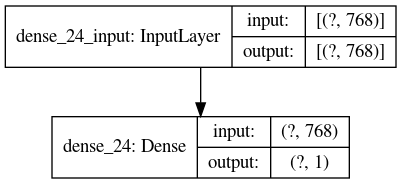

In [123]:
optimizer=Adam(learning_rate=5e-5)
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [124]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/10
686/686 [==============================] - 1s 1ms/step - loss: 0.5155 - accuracy: 0.7627 - val_loss: 0.4510 - val_accuracy: 0.8110
Epoch 2/10
686/686 [==============================] - 1s 997us/step - loss: 0.4586 - accuracy: 0.7994 - val_loss: 0.4518 - val_accuracy: 0.8136
Epoch 3/10
686/686 [==============================] - 1s 1000us/step - loss: 0.4441 - accuracy: 0.8054 - val_loss: 0.4331 - val_accuracy: 0.8228
Epoch 4/10
686/686 [==============================] - 1s 987us/step - loss: 0.4358 - accuracy: 0.8097 - val_loss: 0.4303 - val_accuracy: 0.8228
Epoch 5/10
686/686 [==============================] - 1s 1ms/step - loss: 0.4313 - accuracy: 0.8114 - val_loss: 0.4386 - val_accuracy: 0.8202
Epoch 6/10
686/686 [==============================] - 1s 1ms/step - loss: 0.4290 - accuracy: 0.8129 - val_loss: 0.4275 - val_accuracy: 0.8228
Epoch 7/10
686/686 [==============================] - 1s 999us/step - loss: 0.4238 - accuracy: 0.8155 - val_loss: 0.4302 - val_accuracy: 0.82

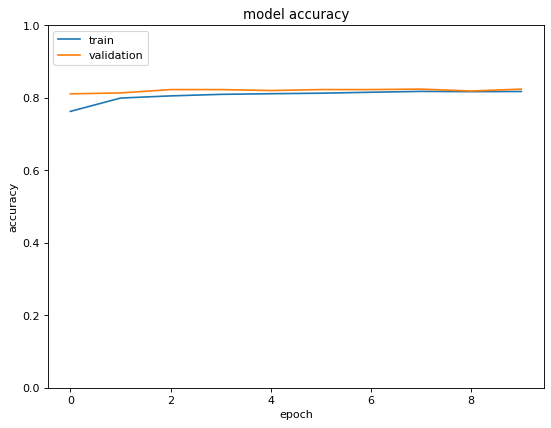

In [125]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [126]:
test_pred = model.predict(bert_test)
test_pred_int = test_pred.round().astype('int')

In [127]:
test['bert_net'] = test_pred
test = test['bert_net'].to_frame()
test.head()

,bert_net
0,0.930810
1,0.979667
2,0.656212
3,0.994964
4,0.963578


In [128]:
test.to_csv('csv/test_red_bert.csv')

In [129]:
train_pred = model.predict(bert_train)
train_pred_int = train_pred.round().astype('int')

In [130]:
train['bert_net'] = train_pred
train = train['bert_net'].to_frame()
train.to_csv('csv/train_red_bert.csv')

# ELMo

In [131]:
train = pd.read_csv('csv/train.csv')
# ids_with_target_error = [328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226]
# train.loc[train['id'].isin(ids_with_target_error),'target'] = 0
test = pd.read_csv('csv/test.csv')
X, y = elmo_train, train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13)

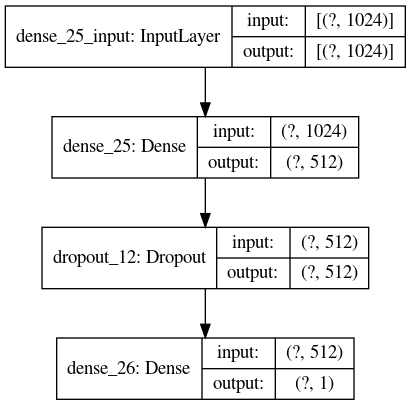

In [132]:
model = Sequential()
model.add(layers.Dense(round(len_elmo/2), input_dim=len_elmo, activation='relu'))
model.add(Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [133]:
optimizer=Adam(learning_rate=5e-5)
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 513       
Total params: 525,313
Trainable params: 525,313
Non-trainable params: 0
_________________________________________________________________


In [134]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/5
686/686 [==============================] - 1s 2ms/step - loss: 0.4811 - accuracy: 0.7831 - val_loss: 0.4459 - val_accuracy: 0.8031
Epoch 2/5
686/686 [==============================] - 1s 2ms/step - loss: 0.4353 - accuracy: 0.8037 - val_loss: 0.4387 - val_accuracy: 0.8071
Epoch 3/5
686/686 [==============================] - 1s 2ms/step - loss: 0.4182 - accuracy: 0.8130 - val_loss: 0.4527 - val_accuracy: 0.7940
Epoch 4/5
686/686 [==============================] - 1s 2ms/step - loss: 0.4016 - accuracy: 0.8259 - val_loss: 0.4407 - val_accuracy: 0.8176
Epoch 5/5
686/686 [==============================] - 2s 2ms/step - loss: 0.3861 - accuracy: 0.8288 - val_loss: 0.4380 - val_accuracy: 0.8163


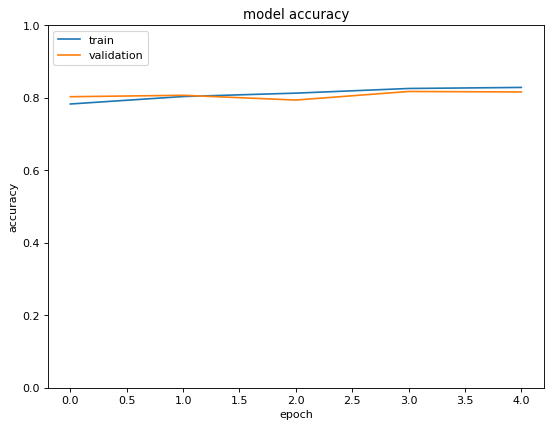

In [135]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [136]:
test_pred = model.predict(elmo_test)
test_pred_int = test_pred.round().astype('int')

In [137]:
test['elmo_net'] = test_pred
test = test['elmo_net'].to_frame()
test.head()

,elmo_net
0,0.670312
1,0.806829
2,0.509133
3,0.944977
4,0.950657


In [138]:
test.to_csv('csv/test_red_elmo.csv')

In [139]:
train_pred = model.predict(elmo_train)
train_pred_int = train_pred.round().astype('int')

In [140]:
train['elmo_net'] = train_pred
train = train['elmo_net'].to_frame()
train.to_csv('csv/train_red_elmo.csv')

# W2V

In [141]:
train = pd.read_csv('csv/train.csv')
# ids_with_target_error = [328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226]
# train.loc[train['id'].isin(ids_with_target_error),'target'] = 0
test = pd.read_csv('csv/test.csv')
X, y = w2v_train, train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13)

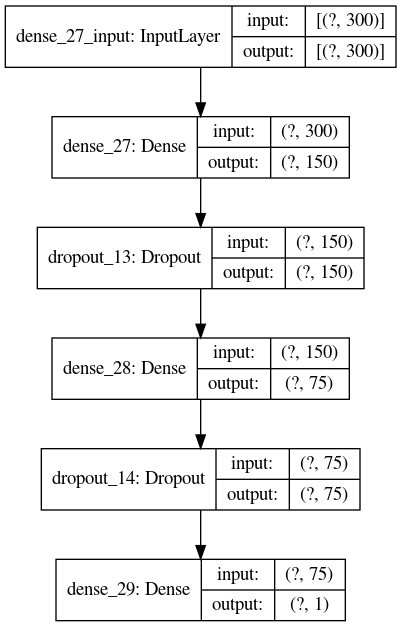

In [142]:
model = Sequential()
model.add(layers.Dense(round(len_w2v/2), input_dim=len_w2v, activation='relu'))
model.add(Dropout(0.25))
model.add(layers.Dense(round(len_w2v/4), input_dim=len_w2v, activation='relu'))
model.add(Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [143]:
optimizer=Adam(learning_rate=5e-5)
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 150)               45150     
_________________________________________________________________
dropout_13 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 75)                11325     
_________________________________________________________________
dropout_14 (Dropout)         (None, 75)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 76        
Total params: 56,551
Trainable params: 56,551
Non-trainable params: 0
_________________________________________________________________


In [144]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/10
686/686 [==============================] - 1s 2ms/step - loss: 0.4898 - accuracy: 0.7729 - val_loss: 0.4495 - val_accuracy: 0.8071
Epoch 2/10
686/686 [==============================] - 1s 2ms/step - loss: 0.4345 - accuracy: 0.8104 - val_loss: 0.4222 - val_accuracy: 0.8215
Epoch 3/10
686/686 [==============================] - 1s 1ms/step - loss: 0.4032 - accuracy: 0.8266 - val_loss: 0.4324 - val_accuracy: 0.8136
Epoch 4/10
686/686 [==============================] - 1s 2ms/step - loss: 0.3734 - accuracy: 0.8421 - val_loss: 0.4357 - val_accuracy: 0.8255
Epoch 5/10
686/686 [==============================] - 1s 2ms/step - loss: 0.3467 - accuracy: 0.8539 - val_loss: 0.4402 - val_accuracy: 0.8189
Epoch 6/10
686/686 [==============================] - 1s 2ms/step - loss: 0.3232 - accuracy: 0.8631 - val_loss: 0.4544 - val_accuracy: 0.8097
Epoch 7/10
686/686 [==============================] - 1s 2ms/step - loss: 0.2974 - accuracy: 0.8774 - val_loss: 0.4627 - val_accuracy: 0.8031
Epoch 

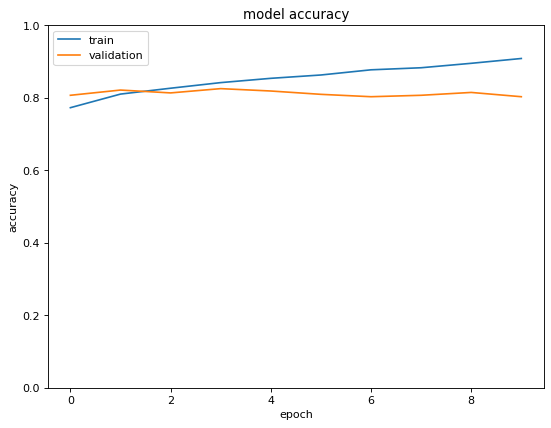

In [145]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [146]:
test_pred = model.predict(w2v_test)
test_pred_int = test_pred.round().astype('int')

In [147]:
test['w2v_net'] = test_pred
test = test['w2v_net'].to_frame()
test.head()

,w2v_net
0,0.820278
1,0.951082
2,0.947077
3,0.999928
4,1.000000


In [148]:
test.to_csv('csv/test_red_w2v.csv')

In [149]:
train_pred = model.predict(w2v_train)
train_pred_int = train_pred.round().astype('int')

In [150]:
train['w2v_net'] = train_pred
train = train['w2v_net'].to_frame()
train.to_csv('csv/train_red_w2v.csv')

# GLOve

In [151]:
train = pd.read_csv('csv/train.csv')
# ids_with_target_error = [328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226]
# train.loc[train['id'].isin(ids_with_target_error),'target'] = 0
test = pd.read_csv('csv/test.csv')
X, y = glove_train, train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13)

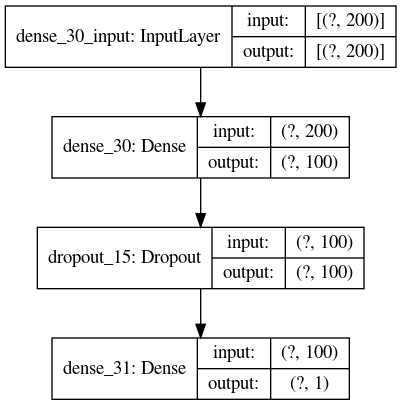

In [152]:
model = Sequential()
model.add(layers.Dense(round(len_glove/2), input_dim=len_glove, activation='relu'))
model.add(Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [153]:
optimizer=Adam(learning_rate=5e-5)
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_15 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 101       
Total params: 20,201
Trainable params: 20,201
Non-trainable params: 0
_________________________________________________________________


In [154]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/5
686/686 [==============================] - 1s 1ms/step - loss: 0.5732 - accuracy: 0.7565 - val_loss: 0.4455 - val_accuracy: 0.8189
Epoch 2/5
686/686 [==============================] - 1s 1ms/step - loss: 0.4400 - accuracy: 0.8048 - val_loss: 0.4211 - val_accuracy: 0.8255
Epoch 3/5
686/686 [==============================] - 1s 1ms/step - loss: 0.4057 - accuracy: 0.8250 - val_loss: 0.4182 - val_accuracy: 0.8386
Epoch 4/5
686/686 [==============================] - 1s 1ms/step - loss: 0.3772 - accuracy: 0.8381 - val_loss: 0.4431 - val_accuracy: 0.8123
Epoch 5/5
686/686 [==============================] - 1s 1ms/step - loss: 0.3533 - accuracy: 0.8537 - val_loss: 0.4183 - val_accuracy: 0.8333


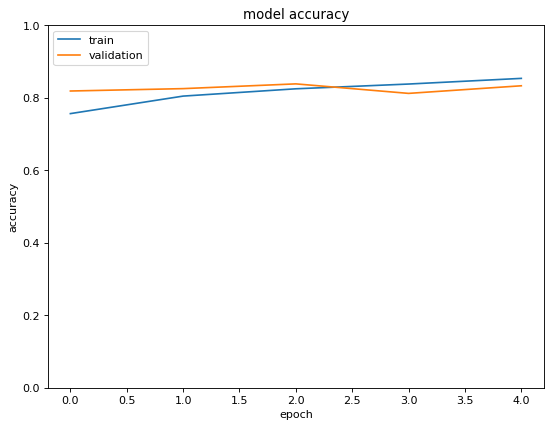

In [155]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [156]:
test_pred = model.predict(glove_test)
test_pred_int = test_pred.round().astype('int')

In [157]:
test['glove_net'] = test_pred
test = test['glove_net'].to_frame()
test.head()

,glove_net
0,0.872468
1,0.943770
2,0.642435
3,0.987758
4,0.997991


In [158]:
test.to_csv('csv/test_red_glove.csv')

In [159]:
train_pred = model.predict(glove_train)
train_pred_int = train_pred.round().astype('int')

In [160]:
train['glove_net'] = train_pred
train = train['glove_net'].to_frame()
train.to_csv('csv/train_red_glove.csv')